# DeepGL - Deep Feature Learning for graphs

We've implemented the [DeepGL](https://arxiv.org/abs/1704.08829) algorithm as a Neo4j procedure and this notebook shows our experiments with it against a SNAP email dataset.

First up let's import some things...

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import manifold
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
import pandas as pd
from neo4j.v1 import GraphDatabase
import tensorflow as tf


# load data
from sklearn.preprocessing import StandardScaler

In [2]:
driver = GraphDatabase.driver("bolt://localhost", auth=("neo4j", "neo"))

Time to load our data into Neo4j.

In [3]:
edge_list_file = "https://github.com/meltzerpete/Embedding-Vis/raw/master/emails/emails.edgelist"
labels_file = "https://github.com/meltzerpete/Embedding-Vis/raw/master/emails/emails.labels"
attributes_file = None

with driver.session() as session:
    session.run("CREATE CONSTRAINT ON (n:Node) ASSERT n.id IS UNIQUE")
    
    result = session.run("""\
        LOAD CSV FROM $edgelistFile AS row
        FIELDTERMINATOR " "
        MERGE (e1:Node {id: row[0]})
        MERGE (e2:Node {id: row[1]})
        MERGE (e1)-[:LINK]->(e2)
        """, {"edgelistFile": edge_list_file})
    print(result.summary().counters)

    result = session.run("""\
        LOAD CSV FROM $labelsFile AS row
        FIELDTERMINATOR " "
        MATCH (e:Node {id: row[0]})
        SET  e.label = toInteger(row[1])-1
        """, {"labelsFile": labels_file})
    print(result.summary().counters)

    if attributes_file is not None:
        result = session.run("""\
            load csv from $attributesFile  as row
            FIELDTERMINATOR " "
            with toString(toInteger(row[0])) AS nodeId, row[1..] AS properties
            MATCH (s:Node {id: nodeId})
            WITH s, properties
            UNWIND range(0, size(properties)-1) AS index
            CALL apoc.create.setProperty(s, "property_" + index, toFloat(properties[index])) YIELD node
            return count(*)
            """, {"attributesFile": attributes_file})
        print(result.summary().counters)

{}
{'properties_set': 1005}


In [10]:
embedding_property_name = "embedding-python"
node_features = []
pruning_lambda = 0.6
diffusions = 3
iterations = 3

In [11]:
with driver.session() as session:
    params = {
        "writeProperty": embedding_property_name,
        "nodeFeatures": node_features,
        "pruningLambda": pruning_lambda,
        "diffusions": diffusions,
        "iterations": iterations
    }
    result = session.run("""
    call
    algo.deepgl(
        null,
        null,
        
        {nodeFeatures: $nodeFeatures,
         pruningLambda: $pruningLambda,
         diffusions: $diffusions,
         iterations: $iterations,
         writeProperty: $writeProperty})
    """, params)
    print(result.peek())

<Record loadMillis=37 computeMillis=230412 writeMillis=166 nodes=1005 writeProperty='embedding-python' embeddingSize=18 numberOfLayers=4 features=['max_out_neighbourhood( max_in_neighbourhood( IN_DEGREE))', 'max_out_neighbourhood( IN_DEGREE)', 'diffuse( hadamard_in_neighbourhood( max_out_neighbourhood( max_in_neighbourhood( IN_DEGREE))))', 'max_out_neighbourhood( mean_out_neighbourhood( IN_DEGREE))', 'diffuse( hadamard_out_neighbourhood( diffuse( rbf_out_neighbourhood( max_in_neighbourhood( IN_DEGREE)))))', 'hadamard_out_neighbourhood( IN_DEGREE)', 'max_out_neighbourhood( mean_out_neighbourhood( hadamard_out_neighbourhood( IN_DEGREE)))', 'IN_DEGREE', 'diffuse( rbf_out_neighbourhood( max_in_neighbourhood( IN_DEGREE)))', 'mean_out_neighbourhood( max_out_neighbourhood( IN_DEGREE))', 'max_in_neighbourhood( IN_DEGREE)', 'mean_out_neighbourhood( max_in_neighbourhood( IN_DEGREE))', 'mean_in_neighbourhood( max_out_neighbourhood( IN_DEGREE))', 'mean_out_neighbourhood( sum_out_neighbourhood( dif

In [12]:
with driver.session() as session:
    result = session.run("""\
    MATCH (n) 
    WITH n.label as class, count(*) AS c
    ORDER BY c DESC
    WITH class WHERE c > 50
    WITH class ORDER BY class
    with collect(class) AS biggestClasses
    MATCH (p:Node) WHERE p.label IN biggestClasses
    RETURN p.`%s` AS embedding, apoc.coll.indexOf(biggestClasses, p.label) AS label, p.label as initialLabel
    ORDER BY label
    """ % embedding_property_name)

    df = pd.DataFrame(dict(row) for row in result)

emb = df["embedding"].apply(pd.Series).values
labels = df["label"].values

/Users/markneedham/projects/Embedding-Vis/a/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


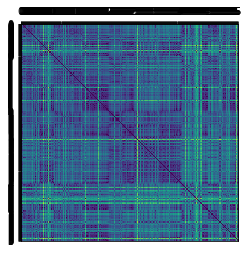

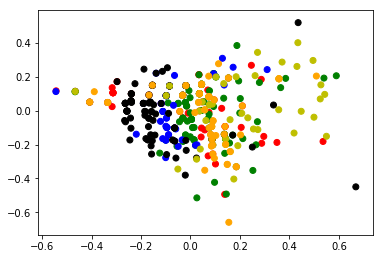

In [7]:
# Heatmap
colours = ['r', 'g', 'b', 'black', 'y', 'orange']
cols = pd.DataFrame(labels).apply(lambda x: colours[int(x)], axis=1).values

dist = np.ndarray([len(emb), len(emb)])

for i, e1 in enumerate(emb):
    for j, e2 in enumerate(emb):
        dist.itemset((i, j), np.linalg.norm(e1 - e2, 2))

plt.imshow(dist)
plt.axes().xaxis.tick_top()
plt.xticks(np.arange(len(dist)), labels)
plt.yticks(np.arange(len(dist)), labels)
plt.show()

# 2D Visualisation
# from: https://baoilleach.blogspot.com/2014/01/convert-distance-matrix-to-2d.html
adist = dist
amax = np.amax(adist)
adist /= amax

mds = manifold.MDS(n_components=2, dissimilarity="precomputed", random_state=6)
results = mds.fit(adist)

coords = results.embedding_

plt.subplots_adjust(bottom=0.1)
plt.scatter(
    coords[:, 0], coords[:, 1], marker='o', c=cols
)

plt.show()

In [13]:
X = pd.DataFrame(emb)
y = labels

X = StandardScaler().fit_transform(X)
train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=.4, random_state=42)

clf = MLPClassifier(solver='sgd',
                    activation='tanh',
                    learning_rate_init=0.001,
                    alpha=1e-5,
                    hidden_layer_sizes=(30, 30),
                    max_iter=10000,
                    batch_size=X.shape[0],
                    random_state=0)

clf.n_outputs_ = 6
clf.out_activation_ = "softmax"
print(clf.get_params())
clf.fit(train_x, train_y)

mean_acc = clf.score(test_x, test_y)
print(mean_acc)

{'activation': 'tanh', 'alpha': 1e-05, 'batch_size': 433, 'beta_1': 0.9, 'beta_2': 0.999, 'early_stopping': False, 'epsilon': 1e-08, 'hidden_layer_sizes': (30, 30), 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'max_iter': 10000, 'momentum': 0.9, 'nesterovs_momentum': True, 'power_t': 0.5, 'random_state': 0, 'shuffle': True, 'solver': 'sgd', 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': False, 'warm_start': False}


/Users/markneedham/projects/Embedding-Vis/a/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:358: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


0.7816091954022989


In [34]:
def train_input_fn(features, labels, batch_size):
    """An input function for training"""
    # Convert the inputs to a Dataset.
    dataset = tf.data.Dataset.from_tensor_slices((dict(features), labels))

    # Shuffle, repeat, and batch the examples.
    dataset = dataset.shuffle(1000).repeat().batch(batch_size)

    # Return the dataset.
    return dataset


def eval_input_fn(features, labels, batch_size):
    """An input function for evaluation or prediction"""
    features = dict(features)
    if labels is None:
        # No labels, use only features.
        inputs = features
    else:
        inputs = (features, labels)

    # Convert the inputs to a Dataset.
    dataset = tf.data.Dataset.from_tensor_slices(inputs)

    # Batch the examples
    assert batch_size is not None, "batch_size must not be None"
    dataset = dataset.batch(batch_size)

    # Return the dataset.
    return dataset

def evaluate(emb, labels):
    data = pd.DataFrame(emb)
    data.columns = [str(col) for col in data.columns.get_values()]
    
    data = StandardScaler().fit_transform(data)
    data = pd.DataFrame(data)
    data.columns = [str(col) for col in data.columns.get_values()]
    
    data["label"] = labels

    train_index = int(len(data) * 0.6)
    train = data[:train_index]
    test = data[train_index:]

    train_x = train.drop("label", axis=1)
    train_y = train["label"]

    test_x = test.drop("label", axis=1)
    test_y = test["label"]

    # Feature columns describe how to use the input.
    my_feature_columns = []
    for key in train_x.keys():
        my_feature_columns.append(tf.feature_column.numeric_column(key=key))

    classifier = tf.estimator.DNNClassifier(
        feature_columns=my_feature_columns,
        # Two hidden layers of 10 nodes each.
        hidden_units=[30, 30],
        # optimizer=
        # activation_fn=tf.nn.softmax,
        # The model must choose between 3 classes.
        n_classes=data["label"].unique().size)

    # Train the Model.
    classifier.train(
        input_fn=lambda: train_input_fn(train_x, train_y, data.shape[0]),
        steps=10000)

    # Evaluate the model.
    eval_result = classifier.evaluate(
        input_fn=lambda: eval_input_fn(test_x, test_y, data.shape[0]))

    print('\nTest set accuracy: {accuracy:0.3f}\n'.format(**eval_result))

In [35]:
evaluate(emb, labels)

INFO:tensorflow:Using default config.


INFO:tensorflow:Using default config.


INFO:tensorflow:Using config: {'_model_dir': '/var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpm2w8ot4a', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x11ab8e160>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpm2w8ot4a', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x11ab8e160>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Saving checkpoints for 1 into /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpm2w8ot4a/model.ckpt.


INFO:tensorflow:Saving checkpoints for 1 into /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpm2w8ot4a/model.ckpt.


INFO:tensorflow:loss = 935.61084, step = 1


INFO:tensorflow:loss = 935.61084, step = 1


INFO:tensorflow:global_step/sec: 130.569


INFO:tensorflow:global_step/sec: 130.569


INFO:tensorflow:loss = 48.26566, step = 101 (0.767 sec)


INFO:tensorflow:loss = 48.26566, step = 101 (0.767 sec)


INFO:tensorflow:global_step/sec: 146.861


INFO:tensorflow:global_step/sec: 146.861


INFO:tensorflow:loss = 24.134993, step = 201 (0.681 sec)


INFO:tensorflow:loss = 24.134993, step = 201 (0.681 sec)


INFO:tensorflow:global_step/sec: 146.355


INFO:tensorflow:global_step/sec: 146.355


INFO:tensorflow:loss = 18.902287, step = 301 (0.684 sec)


INFO:tensorflow:loss = 18.902287, step = 301 (0.684 sec)


INFO:tensorflow:global_step/sec: 149.593


INFO:tensorflow:global_step/sec: 149.593


INFO:tensorflow:loss = 10.666566, step = 401 (0.668 sec)


INFO:tensorflow:loss = 10.666566, step = 401 (0.668 sec)


INFO:tensorflow:global_step/sec: 148.9


INFO:tensorflow:global_step/sec: 148.9


INFO:tensorflow:loss = 12.170609, step = 501 (0.671 sec)


INFO:tensorflow:loss = 12.170609, step = 501 (0.671 sec)


INFO:tensorflow:global_step/sec: 143.894


INFO:tensorflow:global_step/sec: 143.894


INFO:tensorflow:loss = 12.422887, step = 601 (0.695 sec)


INFO:tensorflow:loss = 12.422887, step = 601 (0.695 sec)


INFO:tensorflow:global_step/sec: 147.774


INFO:tensorflow:global_step/sec: 147.774


INFO:tensorflow:loss = 12.039824, step = 701 (0.677 sec)


INFO:tensorflow:loss = 12.039824, step = 701 (0.677 sec)


INFO:tensorflow:global_step/sec: 145.532


INFO:tensorflow:global_step/sec: 145.532


INFO:tensorflow:loss = 9.437569, step = 801 (0.687 sec)


INFO:tensorflow:loss = 9.437569, step = 801 (0.687 sec)


INFO:tensorflow:global_step/sec: 138.206


INFO:tensorflow:global_step/sec: 138.206


INFO:tensorflow:loss = 8.837972, step = 901 (0.724 sec)


INFO:tensorflow:loss = 8.837972, step = 901 (0.724 sec)


INFO:tensorflow:global_step/sec: 139.146


INFO:tensorflow:global_step/sec: 139.146


INFO:tensorflow:loss = 12.130063, step = 1001 (0.719 sec)


INFO:tensorflow:loss = 12.130063, step = 1001 (0.719 sec)


INFO:tensorflow:global_step/sec: 132.821


INFO:tensorflow:global_step/sec: 132.821


INFO:tensorflow:loss = 10.815277, step = 1101 (0.753 sec)


INFO:tensorflow:loss = 10.815277, step = 1101 (0.753 sec)


INFO:tensorflow:global_step/sec: 130.764


INFO:tensorflow:global_step/sec: 130.764


INFO:tensorflow:loss = 8.728095, step = 1201 (0.764 sec)


INFO:tensorflow:loss = 8.728095, step = 1201 (0.764 sec)


INFO:tensorflow:global_step/sec: 130.672


INFO:tensorflow:global_step/sec: 130.672


INFO:tensorflow:loss = 10.27826, step = 1301 (0.765 sec)


INFO:tensorflow:loss = 10.27826, step = 1301 (0.765 sec)


INFO:tensorflow:global_step/sec: 124.902


INFO:tensorflow:global_step/sec: 124.902


INFO:tensorflow:loss = 8.701986, step = 1401 (0.801 sec)


INFO:tensorflow:loss = 8.701986, step = 1401 (0.801 sec)


INFO:tensorflow:global_step/sec: 117.871


INFO:tensorflow:global_step/sec: 117.871


INFO:tensorflow:loss = 9.847471, step = 1501 (0.848 sec)


INFO:tensorflow:loss = 9.847471, step = 1501 (0.848 sec)


INFO:tensorflow:global_step/sec: 116.824


INFO:tensorflow:global_step/sec: 116.824


INFO:tensorflow:loss = 8.103635, step = 1601 (0.856 sec)


INFO:tensorflow:loss = 8.103635, step = 1601 (0.856 sec)


INFO:tensorflow:global_step/sec: 118.042


INFO:tensorflow:global_step/sec: 118.042


INFO:tensorflow:loss = 8.383314, step = 1701 (0.847 sec)


INFO:tensorflow:loss = 8.383314, step = 1701 (0.847 sec)


INFO:tensorflow:global_step/sec: 118.403


INFO:tensorflow:global_step/sec: 118.403


INFO:tensorflow:loss = 10.247944, step = 1801 (0.844 sec)


INFO:tensorflow:loss = 10.247944, step = 1801 (0.844 sec)


INFO:tensorflow:global_step/sec: 117.253


INFO:tensorflow:global_step/sec: 117.253


INFO:tensorflow:loss = 9.4489565, step = 1901 (0.853 sec)


INFO:tensorflow:loss = 9.4489565, step = 1901 (0.853 sec)


INFO:tensorflow:global_step/sec: 116.699


INFO:tensorflow:global_step/sec: 116.699


INFO:tensorflow:loss = 6.499619, step = 2001 (0.857 sec)


INFO:tensorflow:loss = 6.499619, step = 2001 (0.857 sec)


INFO:tensorflow:global_step/sec: 117.096


INFO:tensorflow:global_step/sec: 117.096


INFO:tensorflow:loss = 7.473659, step = 2101 (0.854 sec)


INFO:tensorflow:loss = 7.473659, step = 2101 (0.854 sec)


INFO:tensorflow:global_step/sec: 116.521


INFO:tensorflow:global_step/sec: 116.521


INFO:tensorflow:loss = 7.7584953, step = 2201 (0.858 sec)


INFO:tensorflow:loss = 7.7584953, step = 2201 (0.858 sec)


INFO:tensorflow:global_step/sec: 111.481


INFO:tensorflow:global_step/sec: 111.481


INFO:tensorflow:loss = 9.501306, step = 2301 (0.898 sec)


INFO:tensorflow:loss = 9.501306, step = 2301 (0.898 sec)


INFO:tensorflow:global_step/sec: 114.98


INFO:tensorflow:global_step/sec: 114.98


INFO:tensorflow:loss = 9.212304, step = 2401 (0.869 sec)


INFO:tensorflow:loss = 9.212304, step = 2401 (0.869 sec)


INFO:tensorflow:global_step/sec: 115.104


INFO:tensorflow:global_step/sec: 115.104


INFO:tensorflow:loss = 8.369607, step = 2501 (0.869 sec)


INFO:tensorflow:loss = 8.369607, step = 2501 (0.869 sec)


INFO:tensorflow:global_step/sec: 118.472


INFO:tensorflow:global_step/sec: 118.472


INFO:tensorflow:loss = 7.889144, step = 2601 (0.845 sec)


INFO:tensorflow:loss = 7.889144, step = 2601 (0.845 sec)


INFO:tensorflow:global_step/sec: 117.662


INFO:tensorflow:global_step/sec: 117.662


INFO:tensorflow:loss = 11.276605, step = 2701 (0.849 sec)


INFO:tensorflow:loss = 11.276605, step = 2701 (0.849 sec)


INFO:tensorflow:global_step/sec: 118.415


INFO:tensorflow:global_step/sec: 118.415


INFO:tensorflow:loss = 10.26026, step = 2801 (0.844 sec)


INFO:tensorflow:loss = 10.26026, step = 2801 (0.844 sec)


INFO:tensorflow:global_step/sec: 117.212


INFO:tensorflow:global_step/sec: 117.212


INFO:tensorflow:loss = 9.258955, step = 2901 (0.853 sec)


INFO:tensorflow:loss = 9.258955, step = 2901 (0.853 sec)


INFO:tensorflow:global_step/sec: 114.492


INFO:tensorflow:global_step/sec: 114.492


INFO:tensorflow:loss = 10.738471, step = 3001 (0.874 sec)


INFO:tensorflow:loss = 10.738471, step = 3001 (0.874 sec)


INFO:tensorflow:global_step/sec: 109.792


INFO:tensorflow:global_step/sec: 109.792


INFO:tensorflow:loss = 10.655844, step = 3101 (0.910 sec)


INFO:tensorflow:loss = 10.655844, step = 3101 (0.910 sec)


INFO:tensorflow:global_step/sec: 113.473


INFO:tensorflow:global_step/sec: 113.473


INFO:tensorflow:loss = 10.801181, step = 3201 (0.881 sec)


INFO:tensorflow:loss = 10.801181, step = 3201 (0.881 sec)


INFO:tensorflow:global_step/sec: 115.47


INFO:tensorflow:global_step/sec: 115.47


INFO:tensorflow:loss = 9.4693575, step = 3301 (0.866 sec)


INFO:tensorflow:loss = 9.4693575, step = 3301 (0.866 sec)


INFO:tensorflow:global_step/sec: 115.98


INFO:tensorflow:global_step/sec: 115.98


INFO:tensorflow:loss = 9.550806, step = 3401 (0.862 sec)


INFO:tensorflow:loss = 9.550806, step = 3401 (0.862 sec)


INFO:tensorflow:global_step/sec: 114.077


INFO:tensorflow:global_step/sec: 114.077


INFO:tensorflow:loss = 9.669207, step = 3501 (0.877 sec)


INFO:tensorflow:loss = 9.669207, step = 3501 (0.877 sec)


INFO:tensorflow:global_step/sec: 115.488


INFO:tensorflow:global_step/sec: 115.488


INFO:tensorflow:loss = 7.3946786, step = 3601 (0.866 sec)


INFO:tensorflow:loss = 7.3946786, step = 3601 (0.866 sec)


INFO:tensorflow:global_step/sec: 115.151


INFO:tensorflow:global_step/sec: 115.151


INFO:tensorflow:loss = 8.380282, step = 3701 (0.868 sec)


INFO:tensorflow:loss = 8.380282, step = 3701 (0.868 sec)


INFO:tensorflow:global_step/sec: 117.569


INFO:tensorflow:global_step/sec: 117.569


INFO:tensorflow:loss = 10.7724695, step = 3801 (0.851 sec)


INFO:tensorflow:loss = 10.7724695, step = 3801 (0.851 sec)


INFO:tensorflow:global_step/sec: 117.333


INFO:tensorflow:global_step/sec: 117.333


INFO:tensorflow:loss = 8.277398, step = 3901 (0.852 sec)


INFO:tensorflow:loss = 8.277398, step = 3901 (0.852 sec)


INFO:tensorflow:global_step/sec: 118.496


INFO:tensorflow:global_step/sec: 118.496


INFO:tensorflow:loss = 8.490782, step = 4001 (0.844 sec)


INFO:tensorflow:loss = 8.490782, step = 4001 (0.844 sec)


INFO:tensorflow:global_step/sec: 120.165


INFO:tensorflow:global_step/sec: 120.165


INFO:tensorflow:loss = 10.118711, step = 4101 (0.832 sec)


INFO:tensorflow:loss = 10.118711, step = 4101 (0.832 sec)


INFO:tensorflow:global_step/sec: 120.676


INFO:tensorflow:global_step/sec: 120.676


INFO:tensorflow:loss = 8.224485, step = 4201 (0.829 sec)


INFO:tensorflow:loss = 8.224485, step = 4201 (0.829 sec)


INFO:tensorflow:global_step/sec: 121.439


INFO:tensorflow:global_step/sec: 121.439


INFO:tensorflow:loss = 9.739023, step = 4301 (0.823 sec)


INFO:tensorflow:loss = 9.739023, step = 4301 (0.823 sec)


INFO:tensorflow:global_step/sec: 116.953


INFO:tensorflow:global_step/sec: 116.953


INFO:tensorflow:loss = 8.755011, step = 4401 (0.855 sec)


INFO:tensorflow:loss = 8.755011, step = 4401 (0.855 sec)


INFO:tensorflow:global_step/sec: 116.996


INFO:tensorflow:global_step/sec: 116.996


INFO:tensorflow:loss = 9.049538, step = 4501 (0.855 sec)


INFO:tensorflow:loss = 9.049538, step = 4501 (0.855 sec)


INFO:tensorflow:global_step/sec: 119.02


INFO:tensorflow:global_step/sec: 119.02


INFO:tensorflow:loss = 8.27471, step = 4601 (0.840 sec)


INFO:tensorflow:loss = 8.27471, step = 4601 (0.840 sec)


INFO:tensorflow:global_step/sec: 115.803


INFO:tensorflow:global_step/sec: 115.803


INFO:tensorflow:loss = 9.979662, step = 4701 (0.864 sec)


INFO:tensorflow:loss = 9.979662, step = 4701 (0.864 sec)


INFO:tensorflow:global_step/sec: 116.908


INFO:tensorflow:global_step/sec: 116.908


INFO:tensorflow:loss = 8.419778, step = 4801 (0.855 sec)


INFO:tensorflow:loss = 8.419778, step = 4801 (0.855 sec)


INFO:tensorflow:global_step/sec: 116.661


INFO:tensorflow:global_step/sec: 116.661


INFO:tensorflow:loss = 8.774458, step = 4901 (0.858 sec)


INFO:tensorflow:loss = 8.774458, step = 4901 (0.858 sec)


INFO:tensorflow:global_step/sec: 119.468


INFO:tensorflow:global_step/sec: 119.468


INFO:tensorflow:loss = 7.7184258, step = 5001 (0.837 sec)


INFO:tensorflow:loss = 7.7184258, step = 5001 (0.837 sec)


INFO:tensorflow:global_step/sec: 114.349


INFO:tensorflow:global_step/sec: 114.349


INFO:tensorflow:loss = 6.7205744, step = 5101 (0.874 sec)


INFO:tensorflow:loss = 6.7205744, step = 5101 (0.874 sec)


INFO:tensorflow:global_step/sec: 116.465


INFO:tensorflow:global_step/sec: 116.465


INFO:tensorflow:loss = 9.7314005, step = 5201 (0.859 sec)


INFO:tensorflow:loss = 9.7314005, step = 5201 (0.859 sec)


INFO:tensorflow:global_step/sec: 113.079


INFO:tensorflow:global_step/sec: 113.079


INFO:tensorflow:loss = 7.513086, step = 5301 (0.884 sec)


INFO:tensorflow:loss = 7.513086, step = 5301 (0.884 sec)


INFO:tensorflow:global_step/sec: 104.053


INFO:tensorflow:global_step/sec: 104.053


INFO:tensorflow:loss = 11.283053, step = 5401 (0.961 sec)


INFO:tensorflow:loss = 11.283053, step = 5401 (0.961 sec)


INFO:tensorflow:global_step/sec: 106.42


INFO:tensorflow:global_step/sec: 106.42


INFO:tensorflow:loss = 8.68032, step = 5501 (0.939 sec)


INFO:tensorflow:loss = 8.68032, step = 5501 (0.939 sec)


INFO:tensorflow:global_step/sec: 106.752


INFO:tensorflow:global_step/sec: 106.752


INFO:tensorflow:loss = 9.749211, step = 5601 (0.937 sec)


INFO:tensorflow:loss = 9.749211, step = 5601 (0.937 sec)


INFO:tensorflow:global_step/sec: 104.697


INFO:tensorflow:global_step/sec: 104.697


INFO:tensorflow:loss = 10.103529, step = 5701 (0.955 sec)


INFO:tensorflow:loss = 10.103529, step = 5701 (0.955 sec)


INFO:tensorflow:global_step/sec: 105.855


INFO:tensorflow:global_step/sec: 105.855


INFO:tensorflow:loss = 7.82943, step = 5801 (0.945 sec)


INFO:tensorflow:loss = 7.82943, step = 5801 (0.945 sec)


INFO:tensorflow:global_step/sec: 109.5


INFO:tensorflow:global_step/sec: 109.5


INFO:tensorflow:loss = 6.5260763, step = 5901 (0.913 sec)


INFO:tensorflow:loss = 6.5260763, step = 5901 (0.913 sec)


INFO:tensorflow:global_step/sec: 107.563


INFO:tensorflow:global_step/sec: 107.563


INFO:tensorflow:loss = 8.716719, step = 6001 (0.930 sec)


INFO:tensorflow:loss = 8.716719, step = 6001 (0.930 sec)


INFO:tensorflow:global_step/sec: 110.538


INFO:tensorflow:global_step/sec: 110.538


INFO:tensorflow:loss = 7.9972644, step = 6101 (0.904 sec)


INFO:tensorflow:loss = 7.9972644, step = 6101 (0.904 sec)


INFO:tensorflow:global_step/sec: 110.467


INFO:tensorflow:global_step/sec: 110.467


INFO:tensorflow:loss = 9.409366, step = 6201 (0.905 sec)


INFO:tensorflow:loss = 9.409366, step = 6201 (0.905 sec)


INFO:tensorflow:global_step/sec: 109.696


INFO:tensorflow:global_step/sec: 109.696


INFO:tensorflow:loss = 10.5950985, step = 6301 (0.911 sec)


INFO:tensorflow:loss = 10.5950985, step = 6301 (0.911 sec)


INFO:tensorflow:global_step/sec: 108.591


INFO:tensorflow:global_step/sec: 108.591


INFO:tensorflow:loss = 8.061281, step = 6401 (0.921 sec)


INFO:tensorflow:loss = 8.061281, step = 6401 (0.921 sec)


INFO:tensorflow:global_step/sec: 106.792


INFO:tensorflow:global_step/sec: 106.792


INFO:tensorflow:loss = 10.227528, step = 6501 (0.936 sec)


INFO:tensorflow:loss = 10.227528, step = 6501 (0.936 sec)


INFO:tensorflow:global_step/sec: 104.904


INFO:tensorflow:global_step/sec: 104.904


INFO:tensorflow:loss = 9.026222, step = 6601 (0.953 sec)


INFO:tensorflow:loss = 9.026222, step = 6601 (0.953 sec)


INFO:tensorflow:global_step/sec: 105.283


INFO:tensorflow:global_step/sec: 105.283


INFO:tensorflow:loss = 10.104572, step = 6701 (0.950 sec)


INFO:tensorflow:loss = 10.104572, step = 6701 (0.950 sec)


INFO:tensorflow:global_step/sec: 105.65


INFO:tensorflow:global_step/sec: 105.65


INFO:tensorflow:loss = 9.380661, step = 6801 (0.947 sec)


INFO:tensorflow:loss = 9.380661, step = 6801 (0.947 sec)


INFO:tensorflow:global_step/sec: 104.432


INFO:tensorflow:global_step/sec: 104.432


INFO:tensorflow:loss = 7.471769, step = 6901 (0.957 sec)


INFO:tensorflow:loss = 7.471769, step = 6901 (0.957 sec)


INFO:tensorflow:global_step/sec: 105.543


INFO:tensorflow:global_step/sec: 105.543


INFO:tensorflow:loss = 9.403254, step = 7001 (0.947 sec)


INFO:tensorflow:loss = 9.403254, step = 7001 (0.947 sec)


INFO:tensorflow:global_step/sec: 108.389


INFO:tensorflow:global_step/sec: 108.389


INFO:tensorflow:loss = 9.388148, step = 7101 (0.922 sec)


INFO:tensorflow:loss = 9.388148, step = 7101 (0.922 sec)


INFO:tensorflow:global_step/sec: 109.514


INFO:tensorflow:global_step/sec: 109.514


INFO:tensorflow:loss = 8.698643, step = 7201 (0.914 sec)


INFO:tensorflow:loss = 8.698643, step = 7201 (0.914 sec)


INFO:tensorflow:global_step/sec: 107.726


INFO:tensorflow:global_step/sec: 107.726


INFO:tensorflow:loss = 8.027818, step = 7301 (0.928 sec)


INFO:tensorflow:loss = 8.027818, step = 7301 (0.928 sec)


INFO:tensorflow:global_step/sec: 106.521


INFO:tensorflow:global_step/sec: 106.521


INFO:tensorflow:loss = 10.137035, step = 7401 (0.939 sec)


INFO:tensorflow:loss = 10.137035, step = 7401 (0.939 sec)


INFO:tensorflow:global_step/sec: 105.987


INFO:tensorflow:global_step/sec: 105.987


INFO:tensorflow:loss = 9.81428, step = 7501 (0.944 sec)


INFO:tensorflow:loss = 9.81428, step = 7501 (0.944 sec)


INFO:tensorflow:global_step/sec: 108.203


INFO:tensorflow:global_step/sec: 108.203


INFO:tensorflow:loss = 8.300757, step = 7601 (0.924 sec)


INFO:tensorflow:loss = 8.300757, step = 7601 (0.924 sec)


INFO:tensorflow:global_step/sec: 107.692


INFO:tensorflow:global_step/sec: 107.692


INFO:tensorflow:loss = 8.261146, step = 7701 (0.929 sec)


INFO:tensorflow:loss = 8.261146, step = 7701 (0.929 sec)


INFO:tensorflow:global_step/sec: 105.631


INFO:tensorflow:global_step/sec: 105.631


INFO:tensorflow:loss = 9.806012, step = 7801 (0.947 sec)


INFO:tensorflow:loss = 9.806012, step = 7801 (0.947 sec)


INFO:tensorflow:global_step/sec: 100.77


INFO:tensorflow:global_step/sec: 100.77


INFO:tensorflow:loss = 9.608826, step = 7901 (0.992 sec)


INFO:tensorflow:loss = 9.608826, step = 7901 (0.992 sec)


INFO:tensorflow:global_step/sec: 108.044


INFO:tensorflow:global_step/sec: 108.044


INFO:tensorflow:loss = 6.9809036, step = 8001 (0.925 sec)


INFO:tensorflow:loss = 6.9809036, step = 8001 (0.925 sec)


INFO:tensorflow:global_step/sec: 109.171


INFO:tensorflow:global_step/sec: 109.171


INFO:tensorflow:loss = 8.676278, step = 8101 (0.916 sec)


INFO:tensorflow:loss = 8.676278, step = 8101 (0.916 sec)


INFO:tensorflow:global_step/sec: 110.231


INFO:tensorflow:global_step/sec: 110.231


INFO:tensorflow:loss = 8.05584, step = 8201 (0.907 sec)


INFO:tensorflow:loss = 8.05584, step = 8201 (0.907 sec)


INFO:tensorflow:global_step/sec: 110.09


INFO:tensorflow:global_step/sec: 110.09


INFO:tensorflow:loss = 8.367659, step = 8301 (0.908 sec)


INFO:tensorflow:loss = 8.367659, step = 8301 (0.908 sec)


INFO:tensorflow:global_step/sec: 110.431


INFO:tensorflow:global_step/sec: 110.431


INFO:tensorflow:loss = 9.883025, step = 8401 (0.906 sec)


INFO:tensorflow:loss = 9.883025, step = 8401 (0.906 sec)


INFO:tensorflow:global_step/sec: 109.548


INFO:tensorflow:global_step/sec: 109.548


INFO:tensorflow:loss = 11.5638275, step = 8501 (0.913 sec)


INFO:tensorflow:loss = 11.5638275, step = 8501 (0.913 sec)


INFO:tensorflow:global_step/sec: 110.693


INFO:tensorflow:global_step/sec: 110.693


INFO:tensorflow:loss = 6.955508, step = 8601 (0.904 sec)


INFO:tensorflow:loss = 6.955508, step = 8601 (0.904 sec)


INFO:tensorflow:global_step/sec: 109.463


INFO:tensorflow:global_step/sec: 109.463


INFO:tensorflow:loss = 8.53607, step = 8701 (0.914 sec)


INFO:tensorflow:loss = 8.53607, step = 8701 (0.914 sec)


INFO:tensorflow:global_step/sec: 110.063


INFO:tensorflow:global_step/sec: 110.063


INFO:tensorflow:loss = 7.177973, step = 8801 (0.908 sec)


INFO:tensorflow:loss = 7.177973, step = 8801 (0.908 sec)


INFO:tensorflow:global_step/sec: 109.042


INFO:tensorflow:global_step/sec: 109.042


INFO:tensorflow:loss = 10.486433, step = 8901 (0.917 sec)


INFO:tensorflow:loss = 10.486433, step = 8901 (0.917 sec)


INFO:tensorflow:global_step/sec: 96.0413


INFO:tensorflow:global_step/sec: 96.0413


INFO:tensorflow:loss = 8.47204, step = 9001 (1.041 sec)


INFO:tensorflow:loss = 8.47204, step = 9001 (1.041 sec)


INFO:tensorflow:global_step/sec: 92.9502


INFO:tensorflow:global_step/sec: 92.9502


INFO:tensorflow:loss = 10.556527, step = 9101 (1.076 sec)


INFO:tensorflow:loss = 10.556527, step = 9101 (1.076 sec)


INFO:tensorflow:global_step/sec: 86.0504


INFO:tensorflow:global_step/sec: 86.0504


INFO:tensorflow:loss = 7.491985, step = 9201 (1.162 sec)


INFO:tensorflow:loss = 7.491985, step = 9201 (1.162 sec)


INFO:tensorflow:global_step/sec: 77.6639


INFO:tensorflow:global_step/sec: 77.6639


INFO:tensorflow:loss = 8.212803, step = 9301 (1.291 sec)


INFO:tensorflow:loss = 8.212803, step = 9301 (1.291 sec)


INFO:tensorflow:global_step/sec: 75.2713


INFO:tensorflow:global_step/sec: 75.2713


INFO:tensorflow:loss = 10.468917, step = 9401 (1.326 sec)


INFO:tensorflow:loss = 10.468917, step = 9401 (1.326 sec)


INFO:tensorflow:global_step/sec: 69.8497


INFO:tensorflow:global_step/sec: 69.8497


INFO:tensorflow:loss = 7.4555917, step = 9501 (1.432 sec)


INFO:tensorflow:loss = 7.4555917, step = 9501 (1.432 sec)


INFO:tensorflow:global_step/sec: 57.0712


INFO:tensorflow:global_step/sec: 57.0712


INFO:tensorflow:loss = 6.9239593, step = 9601 (1.755 sec)


INFO:tensorflow:loss = 6.9239593, step = 9601 (1.755 sec)


INFO:tensorflow:global_step/sec: 55.5365


INFO:tensorflow:global_step/sec: 55.5365


INFO:tensorflow:loss = 8.486712, step = 9701 (1.799 sec)


INFO:tensorflow:loss = 8.486712, step = 9701 (1.799 sec)


INFO:tensorflow:global_step/sec: 57.5769


INFO:tensorflow:global_step/sec: 57.5769


INFO:tensorflow:loss = 8.998915, step = 9801 (1.736 sec)


INFO:tensorflow:loss = 8.998915, step = 9801 (1.736 sec)


INFO:tensorflow:global_step/sec: 67.5589


INFO:tensorflow:global_step/sec: 67.5589


INFO:tensorflow:loss = 9.861639, step = 9901 (1.480 sec)


INFO:tensorflow:loss = 9.861639, step = 9901 (1.480 sec)


INFO:tensorflow:Saving checkpoints for 10000 into /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpm2w8ot4a/model.ckpt.


INFO:tensorflow:Saving checkpoints for 10000 into /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpm2w8ot4a/model.ckpt.


INFO:tensorflow:Loss for final step: 6.402175.


INFO:tensorflow:Loss for final step: 6.402175.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2018-07-02-09:30:00


INFO:tensorflow:Starting evaluation at 2018-07-02-09:30:00


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpm2w8ot4a/model.ckpt-10000


INFO:tensorflow:Restoring parameters from /var/folders/k5/ssmkw9vd2yb3h5wnqlxnqbkw0000gn/T/tmpm2w8ot4a/model.ckpt-10000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Finished evaluation at 2018-07-02-09:30:01


INFO:tensorflow:Finished evaluation at 2018-07-02-09:30:01


INFO:tensorflow:Saving dict for global step 10000: accuracy = 0.20114942, average_loss = 20.096546, global_step = 10000, loss = 3496.799


INFO:tensorflow:Saving dict for global step 10000: accuracy = 0.20114942, average_loss = 20.096546, global_step = 10000, loss = 3496.799



Test set accuracy: 0.201

